# Analyze permutate metrics

In [1]:
library(dplyr, warn=FALSE)

In [2]:
# Must manually set
multiplier = 5

In [3]:
stat_df = readr::read_tsv('stats.tsv') %>%
  dplyr::mutate(complete = round(complete * multiplier, 2))
head(stat_df, 2)

,abbrev,attempts,complete,cumulative_attempts,duplicate,excluded,metaedge,same_edge,self_loop,unchanged,undirected_duplicate,permutation
1,GpPW,39023,0.5,39022,0.092612,0,Gene - participates - Pathway,0,0,0.41526,0,1
2,GpPW,39022,1,78044,0.10161,0,Gene - participates - Pathway,0,0,0.19094,0,1


## How many permutations are needed to randomize an edge 

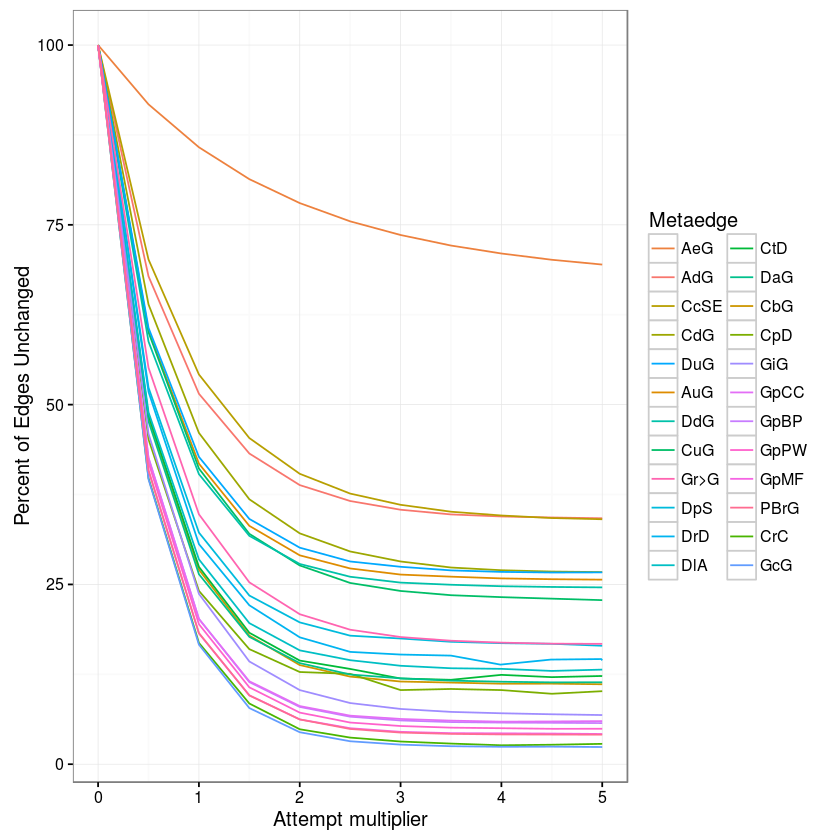

In [4]:
unchanged_df = stat_df %>%
  # Average over permutations
  dplyr::group_by(abbrev, complete) %>%
  dplyr::summarize(unchanged = mean(unchanged)) %>%
  dplyr::ungroup() %>%
  dplyr::bind_rows(dplyr::data_frame(abbrev=unique(stat_df$abbrev), complete = 0, unchanged=1))

abbrevs = unchanged_df %>%
  dplyr::filter(complete == multiplier) %>%
  dplyr::arrange(desc(unchanged)) %>%
  .[['abbrev']]

unchanged_df %>%
  ggplot2::ggplot(ggplot2::aes(x = complete, y = 100 * unchanged, color=abbrev)) +
  ggplot2::geom_line() +
  ggplot2::theme_bw() +
  ggplot2::scale_colour_discrete(breaks = abbrevs, name='Metaedge') +
  ggplot2::xlab('Attempt multiplier') +
  ggplot2::ylab('Percent of Edges Unchanged')

In [5]:
bar_df = stat_df %>%
  tidyr::gather(key = 'measure', value = 'percent', duplicate:excluded, same_edge:undirected_duplicate) %>%
  dplyr::group_by(abbrev, measure) %>%
  dplyr::summarize(
    percent = 100 * weighted.mean(percent, attempts)
  ) %>%
  dplyr::filter(measure != 'excluded')

bar_df$abbrev = factor(bar_df$abbrev, levels=abbrevs)

## What percent of attempts result in a duplicate edge

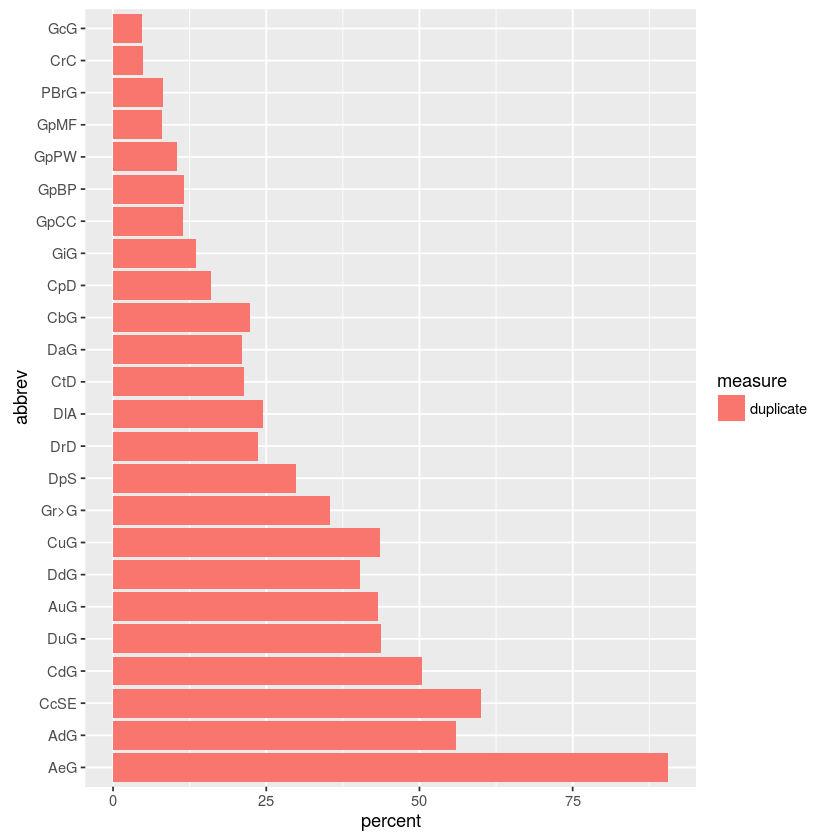

In [6]:
bar_df %>%
  dplyr::filter(measure %in% c('duplicate')) %>%
  ggplot2::ggplot(ggplot2::aes(x = abbrev, y = percent, fill=measure)) +
  ggplot2::geom_bar(stat = "identity", position = "dodge") +
  ggplot2::coord_flip()

## How frequent are other disqualifying factors for each XSwap attempt

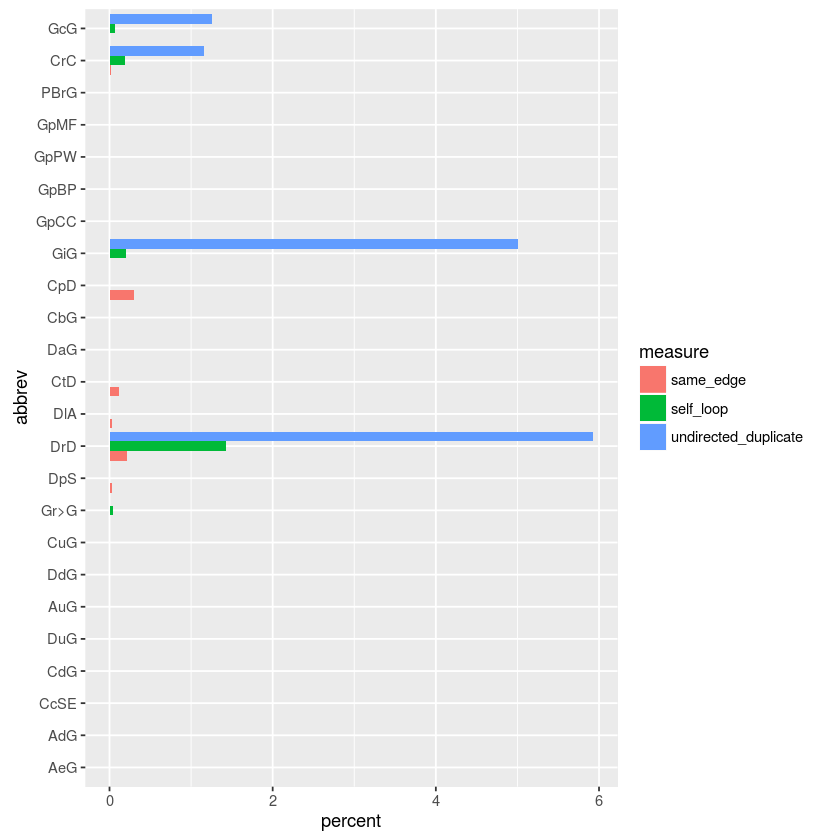

In [7]:
bar_df %>%
  dplyr::filter(!(measure %in% c('duplicate', 'unchanged'))) %>%
  ggplot2::ggplot(ggplot2::aes(x = abbrev, y = percent, fill=measure)) +
  ggplot2::geom_bar(stat = "identity", position = "dodge") +
  ggplot2::coord_flip()